In [358]:
import numpy as np # библиотека для работы с чиселками
import pandas as pd # data processing, работа с CSV файлами
import matplotlib.pyplot as plt # для графики
import seaborn as sns # аналогично
import ast
from scipy.interpolate import CubicSpline
from scipy.optimize import root_scalar
from scipy.optimize import minimize_scalar

In [50]:
## Попробуем применить расчет КПД всей системы чтобы избавиться от лишних данных на входе в модель
## Obschshaya formula kpd systemi PECN imeet vid N=N(st.upr)*N(trans)*N(kabelya)*N(PED)*N(ECN)

#Raschet KPD kabelya:
P=52100 # Iz din dannih
I=46.8 # Iz din dannih
n=1
p=dataset['Удельное сопротивление кабеля'][n]
l=dataset['Длина кабеля'][n]
def KPD_kabelya(n):
  KPD_kabelya=(P)/(P+I**2*(p*l/1000))
  return KPD_kabelya

In [99]:
## Расчет КПД ступеней ЭЦН
# Парсинг паспортных данных ЭЦН
def parse_sections(row):
    try:
        if isinstance(row, str):
            return ast.literal_eval(row)
        return row
    except (ValueError, SyntaxError):
        return []
dataset['rate_points'] = dataset['rate_points'].apply(parse_sections)
dataset['head_points'] = dataset['head_points'].apply(parse_sections)
dataset['power_points'] = dataset['power_points'].apply(parse_sections)
dataset['eff_points'] = dataset['eff_points'].apply(parse_sections)

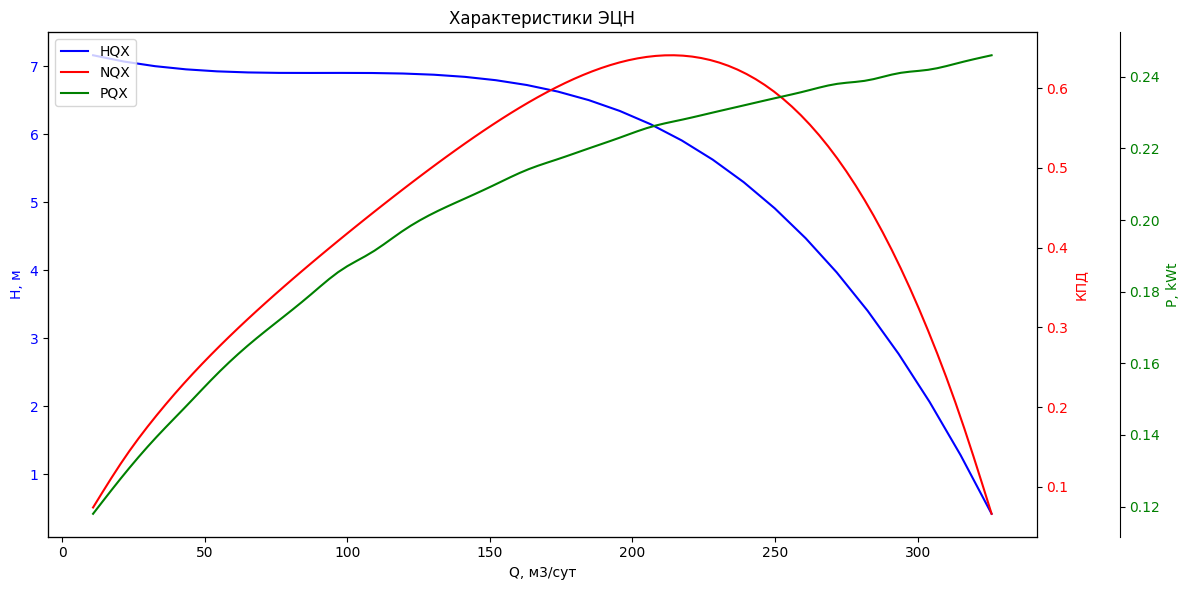

In [336]:
## Совместим паспортные данные
# HQX
x=dataset['rate_points'][0]
y=dataset['head_points'][0]
coeffs = np.polyfit(x, y, deg=3)
HQX = np.poly1d(coeffs)
y_pred = HQX(x)

# NQX
x=dataset['rate_points'][0]
y=dataset['eff_points'][0]
NQX = CubicSpline(x, y, bc_type='natural')
x2 = np.linspace(min(x), max(x), 100)
y2 = NQX(x_spline)

#PQX
x=dataset['rate_points'][0]
y=dataset['power_points'][0]
PQX = CubicSpline(x, y, bc_type='natural')
x3 = np.linspace(min(x), max(x), 100)
y3 = PQX(x3)

fig, ax1 = plt.subplots(figsize=(12, 6))

# График 1 (левая ось Y)
ax1.plot(x, y_pred, color="blue", label="HQX")
ax1.set_xlabel("Q, м3/сут")
ax1.set_ylabel("H, м", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# График 2 (правая ось Y)
ax2 = ax1.twinx()
ax2.plot(x_spline, y2 , color="red", label="NQX")
ax2.set_ylabel("КПД", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# График 3 (третья ось Y, смещенная)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Сдвигаем ось на 60 пикселей
ax3.plot(x3, y3, color="green", label='PQX')
ax3.set_ylabel("P, kWt", color="green")
ax3.tick_params(axis="y", labelcolor="green")

# Объединяем легенды
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2 + lines3,
    labels1 + labels2 + labels3,
    loc="upper left",

)

plt.title("Характеристики ЭЦН")
plt.tight_layout()
plt.show()


In [329]:
## Зададим функцию бисекции
def custom_bisection(func, F_value, a, b, EPSILON=1e-6):

  if (func(a) == F_value):
    return a;
  if (func(b) == F_value):
    return b;

  while ((b-a) >= EPSILON):
      m = (a+b)/2
      if (func(m) == F_value):
        return m
      elif func(m) > F_value:
        b = m
      else:
        a = m

  return m

In [330]:
k=230 #iz din dannix
P=52100/230 #iz din dannix
n=0
Q_min=150 #Iz dannix
Q_max=250 #Iz dannix
a = Q_min-100
b = Q_max+100
P = 0.21
Q_current=custom_bisection(PQX, P, a, b)
N_ecn = NQX(Q_current)

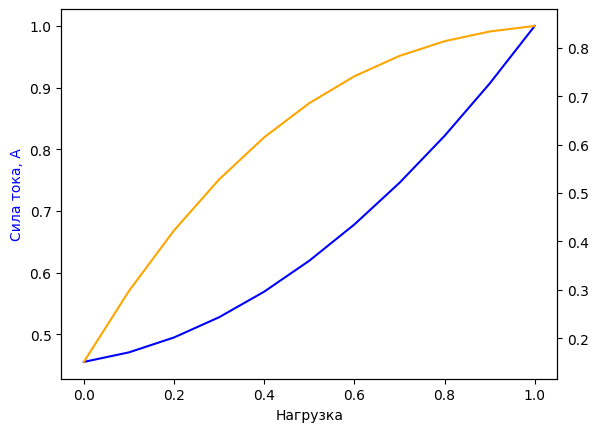

In [359]:
## Расчет КПД привода ЭЦН
# Парсинг паспортных данных ЭЦН
def parse_sections(row):
    try:
        if isinstance(row, str):
            return ast.literal_eval(row)
        return row
    except (ValueError, SyntaxError):
        return []
dataset['load_points'] = dataset['load_points'].apply(parse_sections)
dataset['amperage_points'] = dataset['amperage_points'].apply(parse_sections)
dataset['cosf_points'] = dataset['cosf_points'].apply(parse_sections)
dataset['eff_points'] = dataset['eff_points'].apply(parse_sections)

#ANX
x=dataset['load_points'][0]
y=dataset['amperage_points'][0]
coeffs = np.polyfit(x, y, deg=3)
ANX = np.poly1d(coeffs)
y_pred = ANX(x)
plt.plot(x, y_pred, color='blue', label='Ампераж, А')
plt.xlabel("Нагрузка")
plt.ylabel("Сила тока, А",color='blue')

#CNX
x=dataset['load_points'][0]
y=dataset['cosf_points'][0]
coeffs = np.polyfit(x, y, deg=3)
CNX = np.poly1d(coeffs)
y_pred = CNX(x)
plt= plt.twinx()
plt.plot(x,y_pred, color='orange', label='CosF')



